## Package

In [ ]:
!pip install nsepy
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36084 sha256=56fe1c1bea88ae7ebef9587bc2d157d74197362d395069de54a0ac27d5717cc5
  Stored in directory: /root/.cache/pip/wheels/32/ab/d9/78ceea14cdf6de83376082b3cb0c2999fd77f823e35c47b9ec
Successfully built nsepy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler                   
from tensorflow.keras import Sequential                             
from tensorflow.keras.layers import LSTM,Dense,Dropout,Activation
from sklearn.metrics import mean_squared_error
import numpy as np
import plotly.graph_objects as go
from nsepy import get_history
from datetime import date, datetime, timedelta

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot

## NAV Data Preprocessing

In [ ]:
nav_df = pd.read_csv("NAV.csv")
nav_df.head()

,Net Asset Value,Repurchase Price,Sale Price,NAV date
0,91.031,90.121,91.031,01-Jan-2018
1,90.885,89.976,90.885,02-Jan-2018
2,91.217,90.305,91.217,03-Jan-2018
3,91.697,90.780,91.697,04-Jan-2018
4,91.901,90.982,91.901,05-Jan-2018


In [ ]:
nav_df['NAV date'] =  pd.to_datetime(nav_df['NAV date'], format='%d-%b-%Y')
nav_df.head()

,Net Asset Value,Repurchase Price,Sale Price,NAV date
0,91.031,90.121,91.031,2018-01-01
1,90.885,89.976,90.885,2018-01-02
2,91.217,90.305,91.217,2018-01-03
3,91.697,90.780,91.697,2018-01-04
4,91.901,90.982,91.901,2018-01-05


In [ ]:
#Duplicated data in NAV file
#nav_df[nav_df.duplicated(['NAV date'])] 
nav_df[nav_df['NAV date']=='2020-04-01']

,Net Asset Value,Repurchase Price,Sale Price,NAV date
552,54.614,NaN,NaN,2020-04-01
553,54.614,NaN,NaN,2020-04-01


In [ ]:
nav_df[nav_df['NAV date']=='2020-06-25']

,Net Asset Value,Repurchase Price,Sale Price,NAV date
662,67.483,NaN,NaN,2020-06-25
663,67.483,NaN,NaN,2020-06-25


In [ ]:
nav_df_dedup = nav_df.groupby(['NAV date']).agg(max)
nav_df_dedup = nav_df_dedup.reset_index()
nav_df_dedup = nav_df_dedup.sort_values("NAV date")
print(nav_df_dedup.head())

    NAV date  Net Asset Value  Repurchase Price  Sale Price
0 2018-01-01           91.031            90.121      91.031
1 2018-01-02           90.885            89.976      90.885
2 2018-01-03           91.217            90.305      91.217
3 2018-01-04           91.697            90.780      91.697
4 2018-01-05           91.901            90.982      91.901


In [ ]:
nav_df_dedup[nav_df_dedup['NAV date']=='2020-06-25']

,NAV date,Net Asset Value,Repurchase Price,Sale Price
607,2020-06-25,67.483,NaN,NaN


In [ ]:
SBI_df = get_history(symbol="SBIN", start=date(2018,1,1), end=date.today())
SBI_df = SBI_df.reset_index()
SBI_df['Date'] =  pd.to_datetime(SBI_df['Date'], format='%Y-%m-%d')
SBI_df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2018-01-01,SBIN,EQ,309.90,310.6,312.75,306.30,306.75,307.10,309.08,12182400,3.765315e+14,75769,5697288,0.4677
1,2018-01-02,SBIN,EQ,307.10,309.0,309.00,301.35,303.00,303.25,304.00,14797364,4.498328e+14,100195,5698196,0.3851
2,2018-01-03,SBIN,EQ,303.25,305.3,306.45,302.15,302.80,302.85,304.32,13857373,4.217070e+14,117207,6941140,0.5009
3,2018-01-04,SBIN,EQ,302.85,304.5,310.20,303.15,309.25,308.50,307.63,24517099,7.542211e+14,140513,10508054,0.4286
4,2018-01-05,SBIN,EQ,308.50,311.4,311.40,305.60,307.25,306.35,308.05,14580575,4.491544e+14,91829,4896408,0.3358


In [ ]:
cond = ~nav_df_dedup['NAV date'].isin(SBI_df['Date']) 
nav_df_dedup.drop(nav_df_dedup[cond].index, inplace = True)
nav_df_dedup['Date'] = nav_df_dedup['NAV date']
nav_df_dedup.head()

,NAV date,Net Asset Value,Repurchase Price,Sale Price,Date
0,2018-01-01,91.031,90.121,91.031,2018-01-01
1,2018-01-02,90.885,89.976,90.885,2018-01-02
2,2018-01-03,91.217,90.305,91.217,2018-01-03
3,2018-01-04,91.697,90.780,91.697,2018-01-04
4,2018-01-05,91.901,90.982,91.901,2018-01-05


In [ ]:
nav_df_final = nav_df_dedup[['Date','Net Asset Value']]
nav_df_final.head()

,Date,Net Asset Value
0,2018-01-01,91.031
1,2018-01-02,90.885
2,2018-01-03,91.217
3,2018-01-04,91.697
4,2018-01-05,91.901


In [ ]:
stocks = ["ICICIBANK", "HDFCBANK", "SBIN", "HCLTECH", "INFY"]
for stock in stocks:
  new_ndf = nav_df_final
  df = get_history(symbol=stock, start=date(2018,1,1), end=date.today())
  df = df.reset_index()
  df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
  cond = ~new_ndf['Date'].isin(df['Date']) 
  new_ndf.drop(new_ndf[cond].index, inplace = True)
  df = pd.merge(df, new_ndf, on="Date")
  nav_df_final[stock + " Close"] = df["Close"]

print(len(nav_df_final))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


1102


In [ ]:
nav_df_final.head()

,Date,Net Asset Value,ICICIBANK Close,HDFCBANK Close,SBIN Close,HCLTECH Close,INFY Close
0,2018-01-01,91.031,310.3,1854.50,307.10,878.70,1033.55
1,2018-01-02,90.885,309.7,1872.35,303.25,892.80,1029.70
2,2018-01-03,91.217,315.0,1852.65,302.85,897.30,1021.30
3,2018-01-04,91.697,314.7,1859.90,308.50,893.10,1015.40
4,2018-01-05,91.901,312.9,1863.60,306.35,900.05,1012.00


In [ ]:
nav_df_final.tail()

,Date,Net Asset Value,ICICIBANK Close,HDFCBANK Close,SBIN Close,HCLTECH Close,INFY Close
1097,2022-06-15,121.639,687.25,1307.45,451.35,989.90,1422.20
1098,2022-06-16,119.186,678.50,1281.30,441.60,964.95,1397.20
1099,2022-06-17,118.514,686.85,1289.75,441.00,958.75,1387.30
1100,2022-06-20,117.256,685.95,1322.15,434.70,960.05,1414.15
1101,2022-06-21,119.915,696.10,1336.55,450.75,986.60,1449.90


## NAV Multivariate Model building

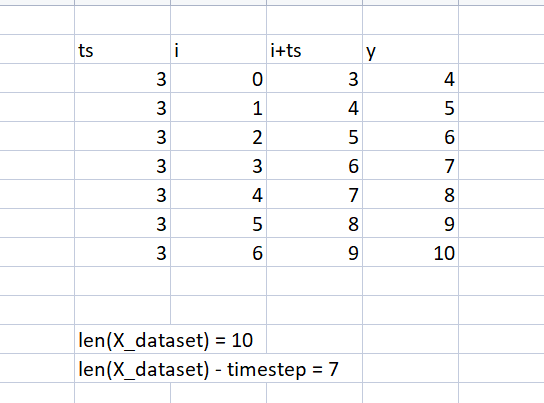

In [ ]:
time_step = 30
train_test_split = 0.80
batch_size = 8
no_of_epochs = 50 

X_train = []
y_train = []
X_test = []
y_test = []

In [ ]:
# We are going to predict the closing price of the stock, so in the columns of stock we have the price_type parameter. We can use this.
data = np.asarray(nav_df_final['Net Asset Value'])
# Reshaping to automatically make it a 2d-array which is the input for sequential model
data = data.reshape(-1, 1)
# We find the index for train_test_split as spefied ratio by the user above in the parameters
training_data_len = int(len(nav_df_final) * train_test_split)
print(training_data_len)
# Return dates
dates = nav_df_final['Date']

881


In [ ]:
# We are going to predict the closing price of the stock multivariate with Traded Quantity, so in the columns of stock we have the price_type parameter. We can use this.
ndata = np.asarray(nav_df_final[['Net Asset Value','ICICIBANK Close','HDFCBANK Close','SBIN Close','HCLTECH Close','INFY Close']])

# We scale the data to make the data modelling easier
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))
x_scaled_data = x_scaler.fit_transform(ndata)
y_scaled_data = y_scaler.fit_transform(data)
# We find the index for train_test_split as spefied ratio by the user above in the parameters
x_train_data = x_scaled_data[0:training_data_len]
x_test_data = x_scaled_data[training_data_len-time_step:]
y_train_data = y_scaled_data[0:training_data_len]
y_test_data = y_scaled_data[training_data_len-time_step:]

print("x_train_data -->",x_train_data.shape)
print("x_test_data -->",x_test_data.shape)
print("y_train_data -->",y_train_data.shape)
print("y_test_data -->",y_test_data.shape)

x_train_data --> (881, 6)
x_test_data --> (251, 6)
y_train_data --> (881, 1)
y_test_data --> (251, 1)


In [ ]:
dataX, dataY = [], []
for i in range(len(x_train_data) - time_step) :
  dataX.append(x_train_data[i: (i + time_step)])
for i in range(len(y_train_data) - time_step) :
  #X_dataset is already an 2d array but y_dataset is 1d and hence we are reshaping y to 2d by passing 0 as dummy
  dataY. append(y_train_data[i + time_step, 0])
X_train, y_train = np.array(dataX), np.array(dataY)

In [ ]:
dataX, dataY = [], []
for i in range(len(x_test_data) - time_step) :
  dataX.append(x_test_data[i: (i + time_step)])
for i in range(len(y_test_data) - time_step) :
  #X_dataset is already an 2d array but y_dataset is 1d and hence we are reshaping y to 2d by passing 0 as dummy
  dataY. append(y_test_data[i + time_step, 0])
X_test, y_test = np.array(dataX), np.array(dataY)

In [ ]:
print("After splitting into time steps: Input for the model")
print("x_train -->",X_train.shape)
print("x_test -->",X_test.shape)
print("y_train -->",y_train.shape)
print("y_test -->",y_test.shape)

After splitting into time steps: Input for the model
x_train --> (851, 30, 6)
x_test --> (221, 30, 6)
y_train --> (851,)
y_test --> (221,)


In [ ]:
nav_model = Sequential()
nav_model.add(LSTM(units = 32, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
nav_model.add(LSTM(units = 30, return_sequences = False))
# nav_model.add(LSTM(units = 30, return_sequences = False))
# nav_model.add(Dropout(0.5))
nav_model.add(Dense(1))

nav_model.compile(optimizer='rmsprop', loss='mean_squared_error')
nav_model.summary()
nav_model.fit(X_train, y_train, batch_size = batch_size, epochs = no_of_epochs, verbose = True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 32)            4992      
                                                                 
 lstm_13 (LSTM)              (None, 30)                7560      
                                                                 
 dense_6 (Dense)             (None, 1)                 31        
                                                                 
Total params: 12,583
Trainable params: 12,583
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
107/107 [==============================] - 7s 25ms/step - loss: 0.0049
Epoch 2/50
107/107 [==============================] - 3s 25ms/step - loss: 0.0017
Epoch 3/50
107/107 [==============================] - 3s 25ms/step - loss: 0.0013
Epoch 4/50
107/107 [==============================] - 3s 25ms/step -

In [ ]:
 #Predicts the data for X_test
predictions = nav_model.predict(X_test)
mse_scalled = np.mean(predictions-y_test)**2
print(mse_scalled)

0.00015934582631837524


In [ ]:
#Inverse Scalar Tranform into original scale
y_test_actu = y_scaler.inverse_transform(y_test.reshape(-1,1))
y_test_pred = y_scaler.inverse_transform(predictions.reshape(-1,1))
mse = np.mean(y_test_actu-y_test_pred)**2
mse

1.0534102530402525

In [ ]:
print("****************************************")
print("PREDICTED DATA","\t","ACTUAL DATA")
print("****************************************")
for i in range(len(y_test_actu)):
  print(y_test_pred[i][0],"\t",y_test_actu[i][0])
print()
print("****************************************")
print()

****************************************
PREDICTED DATA 	 ACTUAL DATA
****************************************
113.0599 	 109.061
112.155045 	 109.80999999999999
112.823814 	 110.915
114.01867 	 111.391
115.14179 	 111.035
113.89426 	 110.413
113.5682 	 109.813
113.43265 	 109.123
112.76318 	 108.971
112.62691 	 109.726
113.04608 	 110.528
113.64981 	 110.275
113.136086 	 109.955
113.0684 	 109.606
112.505424 	 107.808
111.02529 	 107.593
111.25879 	 108.86199999999998
112.2071 	 109.30899999999998
112.10279 	 109.267
112.0953 	 109.901
112.52044 	 111.414
114.043655 	 112.212
114.61943 	 112.158
114.88058 	 112.75
115.39427 	 113.52
115.87413 	 113.54499999999999
115.93632 	 113.308
115.656494 	 113.43499999999999
115.99921 	 113.59099999999998
116.027145 	 113.50099999999999
115.68213 	 113.894
115.8622 	 115.314
117.12617 	 116.287
118.49494 	 115.64600000000002
117.21553 	 113.933
115.67165 	 114.465
116.17623 	 114.65899999999999
115.72642 	 116.089
117.19982 	 115.493
116.25957 	

In [ ]:
train = []
for dat in data[:training_data_len]:
  train.append(dat[0])

test = []
for dat in y_test_actu:
  test.append(dat[0])

predict = []
for i in y_test_pred:
  predict.append(i[0])

date_train = list(dates)[:training_data_len]
date_test = list(dates)[training_data_len:]

y_axis = [train, test, predict]
x_axis = [date_train, date_test, date_test]
labels = ["Train", "Test", "Predicted Test"]

# Init figure
fig = go.Figure()

if( (len(x_axis) != len(y_axis)) ):
  # Empty fig because data doesn't match
  fig.show()

else:
  # Adding the data to the trace
  for i in range(len(y_axis)):
    if(len(labels) == 0):
      fig.add_trace(go.Scatter(x=x_axis[i], y=y_axis[i],mode='lines',name=str(i+1)+"-value"))
    else:
      fig.add_trace(go.Scatter(x=x_axis[i], y=y_axis[i],mode='lines',name=labels[i]))
  
  # Axis updation option
  fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1,
                            label='1y',
                            step='year',
                            stepmode='todate'),
                      dict(count=2,
                            label='2y',
                            step='year',
                            stepmode='todate'),
                      dict(count=3,
                            label='3y',
                            step='year',
                            stepmode='todate'),
                      dict(step='all')
        ])
    )
  )

  # Layout definition
  fig.update_layout(
    title={'text': 'NAV Model',
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
    xaxis_title="Date",
    yaxis_title="Data",
  )
  fig.show()

## Residual

In [ ]:
train_predictions = nav_model.predict(X_train)
y_train_actu = y_scaler.inverse_transform(y_train.reshape(-1,1))
y_train_pred = y_scaler.inverse_transform(train_predictions.reshape(-1,1))
train_residuals = y_train_actu - y_train_pred
train_residuals = train_residuals.flatten()
train_residuals

array([ 2.01482263e+00,  2.00948010e+00,  7.81337646e-01,  4.35601807e-01,
        8.37379761e-01,  7.26772095e-01,  9.38585205e-02,  1.40847400e+00,
        1.90739166e+00,  9.05688599e-01,  1.23100793e+00,  8.19147705e-01,
        9.75852051e-01, -1.13502930e-01, -2.19533386e-01,  1.47580151e+00,
        1.35607422e-01,  8.96242126e-01,  8.40247986e-01,  3.05401672e-01,
        2.80040100e-01, -5.18384094e-01, -5.61638306e-01,  2.23843445e-01,
        5.74525757e-01, -5.95369812e-01, -6.08950317e-01,  1.44803674e+00,
        1.44232642e+00,  4.05813110e-01,  1.90230743e+00,  2.63847589e+00,
        7.67385803e-01,  2.18252435e+00,  9.64612549e-01,  8.73499451e-01,
        9.18099609e-01,  3.32100342e-01,  8.50221619e-01,  7.69312988e-01,
        7.72499451e-01,  1.02074860e+00,  9.16921997e-01,  1.20409528e+00,
        1.07063916e+00,  1.58195551e+00,  1.23507440e+00,  6.77552246e-01,
        1.06261865e+00,  1.79073676e+00,  1.63795435e+00,  9.31187927e-01,
        9.94395508e-01,  

In [ ]:
# model the training set residuals
window = 30
res_model = AutoReg(train_residuals, lags=30)
model_fit = res_model.fit()
coef = model_fit.params

In [ ]:
# walk forward over time steps in test
history = train_residuals[len(train_residuals)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(y_test_actu)):
  # persistence
  yhat = y_test_pred[t]
  error = y_test_actu[t] - yhat
  # predict error
  length = len(history)
  lag = [history[i] for i in range(length-window,length)]
  pred_error = coef[0]
  for d in range(window):
    pred_error += coef[d+1] * lag[window-d-1]
  # correct the prediction
  
  yhat = yhat + pred_error
  predictions.append(yhat)
  history.append(error)
  print('predicted: ',yhat[0],' Expected: ', y_test_actu[t][0])
  # error
pred_error = pred_error[0]
rmse = np.sqrt(mean_squared_error(y_test_actu, predictions))
print('Test RMSE: %.3f' % rmse)
print('Prediction error: ',pred_error)

predicted:  110.0249  Expected:  109.061
predicted:  108.90860598771435  Expected:  109.80999999999999
predicted:  109.82044260025008  Expected:  110.915
predicted:  111.4703273228839  Expected:  111.391
predicted:  112.5684647561858  Expected:  111.035
predicted:  110.44279768040762  Expected:  110.413
predicted:  110.72645293309836  Expected:  109.813
predicted:  110.16536431432655  Expected:  109.123
predicted:  109.03305751035923  Expected:  108.971
predicted:  109.3705077248294  Expected:  109.726
predicted:  110.0395382079805  Expected:  110.528
predicted:  110.77687988745411  Expected:  110.275
predicted:  109.8999885741422  Expected:  109.955
predicted:  109.89514999405519  Expected:  109.606
predicted:  109.18463735717206  Expected:  107.808
predicted:  107.28165639457691  Expected:  107.593
predicted:  107.81179099423765  Expected:  108.86199999999998
predicted:  109.31488083125845  Expected:  109.30899999999998
predicted:  109.03226777002502  Expected:  109.267
predicted:  1

In [ ]:
train = []
for dat in data[:training_data_len]:
  train.append(dat[0])

test = []
for dat in y_test_actu:
  test.append(dat[0])

predict = []
for i in predictions:
  predict.append(i[0])

date_train = list(dates)[:training_data_len]
date_test = list(dates)[training_data_len:]

y_axis = [train, test, predict]
x_axis = [date_train, date_test, date_test]
labels = ["Train", "Test", "Predicted Test"]

# Init figure
fig = go.Figure()

if( (len(x_axis) != len(y_axis)) ):
  # Empty fig because data doesn't match
  fig.show()

else:
  # Adding the data to the trace
  for i in range(len(y_axis)):
    if(len(labels) == 0):
      fig.add_trace(go.Scatter(x=x_axis[i], y=y_axis[i],mode='lines',name=str(i+1)+"-value"))
    else:
      fig.add_trace(go.Scatter(x=x_axis[i], y=y_axis[i],mode='lines',name=labels[i]))
  
  # Axis updation option
  fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1,
                            label='1y',
                            step='year',
                            stepmode='todate'),
                      dict(count=2,
                            label='2y',
                            step='year',
                            stepmode='todate'),
                      dict(count=3,
                            label='3y',
                            step='year',
                            stepmode='todate'),
                      dict(step='all')
        ])
    )
  )

  # Layout definition
  fig.update_layout(
    title={'text': 'NAV Model',
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
    xaxis_title="Date",
    yaxis_title="Data",
  )
  fig.show()

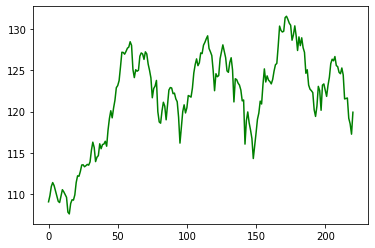

In [ ]:
pyplot.plot(y_test_actu, color='green')
pyplot.show()

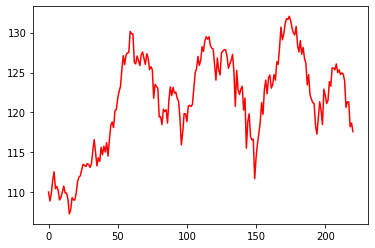

In [ ]:
pyplot.plot(predictions, color='red')
pyplot.show()

## Tomorrow's NAV Prediction

In [ ]:
#This should give me next day predicted value

ndata = np.asarray(nav_df_final[['Net Asset Value','ICICIBANK Close','HDFCBANK Close','SBIN Close','HCLTECH Close','INFY Close']])
data_list = list(ndata)

last = data_list[-time_step:]
last_data = np.array(last, dtype='float32')
last_scalled = x_scaler.transform(last_data)
x_test_final = last_scalled
x_test_final = np.reshape(x_test_final,(1, x_test_final.shape[0],x_test_final.shape[1]))
prediction = nav_model.predict(x_test_final)
prediction = y_scaler.inverse_transform(prediction)
next_days = prediction[0][0]

print("NEXT DAYS", next_days)


NEXT DAYS 117.856804


In [ ]:
#With Residual error:
lag = [history[i] for i in range(length-window,length)]
pred_error = coef[0]
for d in range(window):
  pred_error += coef[d+1] * lag[window-d-1]
print("NEXT DAYS : After residual", next_days+pred_error[0])

NEXT DAYS : After residual 119.30292097337528
